### Add an equation for the vapor mixing ratio

In [1]:
def theta_ft(h,ft_intercept,gamma):
    """
       input h (meters) and the coefficients for the linear
       profile for the free troposphere theta (ft_intercept (K)  and slope gamma (K/m))
       return the free tropospher theta at height h
    """
    theta_top = ft_intercept + h*gamma
    return theta_top

#
# helper function to turn a dictionary into a named tuple
#
from collections import namedtuple
def make_tuple(tupname,in_dict):
    the_tup = namedtuple(tupname, in_dict.keys())
    the_tup = the_tup(**in_dict)
    return the_tup


In [2]:
%matplotlib inline
import numpy as np
import scipy.integrate as integrate
from matplotlib import pyplot as plt
import pandas as pd
import thermlib
from importlib import reload
reload(thermlib)
from thermlib import thermfuncs as tf



def dmixed_vars(the_vars,tstep,coeffs):
    """
      the_vars[0]= thetabar
      the_vars[1] = h
      the_vars[2] = qv
      
      surface flux from drag law with subsidence and diagnosed deltheta
    """
    #print('the_vars: ',the_vars,D,U)
    deltheta = theta_ft(the_vars[1],coeffs.ft_intercept,coeffs.ft_gamma) - the_vars[0]
    F0 = coeffs.U*coeffs.Cd*(coeffs.sst - the_vars[0])  #surface heat flux
    Fqv0 = coeffs.U*coeffs.Cd*(coeffs.qsfc - the_vars[2])  #surface vapor flux
    Fint = -coeffs.k*F0  #entrainment heat flux
    went = -Fint/deltheta  #entrainment velocity (positive upward)
    Fqvent = -went*( coeffs.ft_qv - the_vars[2])
    wsubs = -coeffs.D*the_vars[1]
    rho=1.
    cp=1004.
    derivs=np.empty_like(the_vars)
    derivs[0]=(F0 - Fint)/(the_vars[1]*rho) - coeffs.radcool/1004./the_vars[1]
    derivs[1] = went + wsubs
    derivs[2] = (Fqv0 - Fqvent)/the_vars[1]
    return derivs

In [3]:
reload(thermlib)
from thermlib import thermfuncs as tf
dtout=10.  #minutes
end_time=8*24.   #hours
del_time=dtout*60. #seconds
end_time=end_time*3600. #seconds
sst=297
D=5.e-6  #s-1
U=7  #m/s
psfc=100. #kPa
qsfc=tf.qs_tp(sst,psfc)
ft_intercept = 292 #K
ft_gamma = 6.e-3  #K/m
ft_qv = 2.e-3
k=0.2  #entrainment efficiency
Cd = 1.e-3  #drag coefficient
tspan = np.arange(0.,end_time,del_time)
vars_init=[285.,400.,8.e-3]  #theta (K), height (m) qv (kg/kg) to start
the_tup=dict(D=D,U=U,sst=sst,ft_intercept=ft_intercept,ft_gamma=ft_gamma,
             qsfc=qsfc,ft_qv=ft_qv,k=k,Cd=Cd,radcool=30.)
the_tup=make_tuple('coeffs',the_tup)
output=integrate.odeint(dmixed_vars, vars_init, tspan,(the_tup,))
result=pd.DataFrame.from_records(output,columns=['theta','h','qv'])
result['time']=tspan/3600./24.  #days
result['deltheta'] = theta_ft(result['h'].values,ft_intercept,ft_gamma) - result['theta']

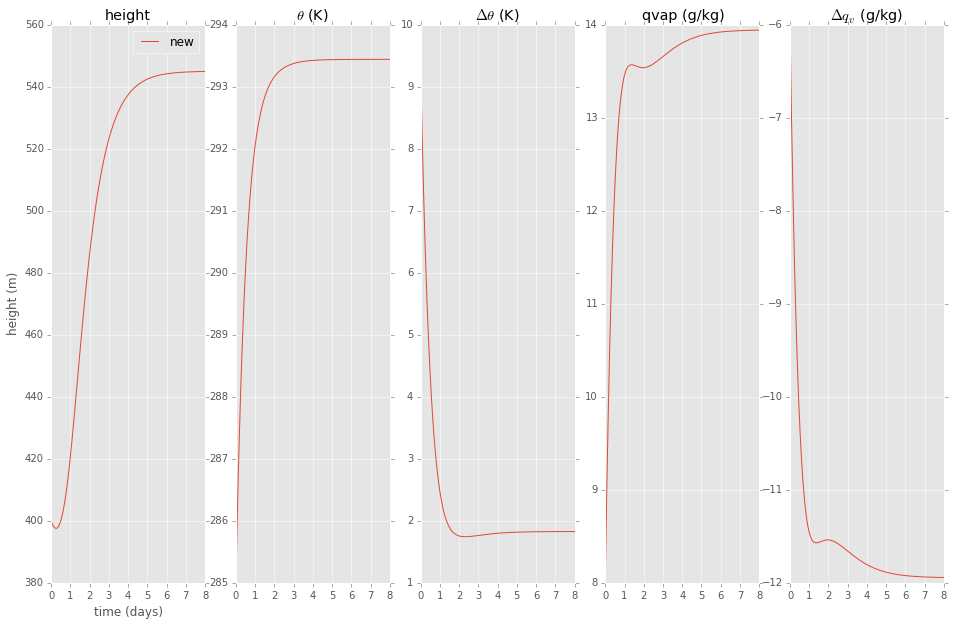

In [4]:
%matplotlib inline
plt.close('all')
plt.style.use('ggplot')
fig,ax = plt.subplots(1,5,figsize=(16,10))
ax[0].plot(result['time'],result['h'],label='new')
ax[0].set(ylabel='height (m)',xlabel='time (days)',title='height')
ax[0].legend(loc='best')
ax[1].plot(result['time'],result['theta'],label='new')
out=ax[1].set(title=r'$\theta$ (K)')
out=ax[2].plot(result['time'],result['deltheta'],label='new')
out=ax[2].set(title=r'$\Delta \theta$ (K)')
out=ax[3].plot(result['time'],result['qv']*1.e3,label='new')
out=ax[3].set(title='qvap (g/kg)')
result['delqv'] = ft_qv - result['qv']
out=ax[4].plot(result['time'],result['delqv']*1.e3)
out=ax[4].set(title=r'$\Delta q_v$ (g/kg)')

### get the flux profiles and the cloud thickness

the next cell applies the calc_lcl function to every row in the dataframe and
adds it as a new column

In [5]:
reload(thermlib)
from thermlib import thermfuncs as tf
def calc_lcl(row,psfc):
    """
      find the lcl (in m) for a row in the dataframe
    """
    Tdew = tf.tmr(row['qv'],psfc)
    LCL = tf.LCL(Tdew,row['theta'],psfc)  #kPa
    #
    # rough approximation:  10 kPa = 1 km
    #
    delp=psfc - LCL
    lcl_h = delp*100.
    return lcl_h


def calc_sfc_theta_flux(row,coeffs):
    F0 = coeffs.U*coeffs.Cd*(coeffs.sst - row['theta'])  #surface heat flux
    return F0

def calc_sfc_qvap_flux(row,coeffs):
    Fqv0 = coeffs.U*coeffs.Cd*(coeffs.qsfc[0] - row['qv'])
    return Fqv0

def calc_entflux_theta(row,coeffs):
    flux_ent = -coeffs.k*row['T_flux_0']
    return flux_ent

def calc_went(row,coeffs):
    went = -row['entflux_theta']/row['deltheta']
    return went
    
def calc_entflux_qv(row,coeffs):
    flux_ent =  -row['went']*( coeffs.ft_qv - row['qv'])
    return flux_ent


result['LCL']=result.apply(calc_lcl,axis=1,args=(psfc,))
result['q_flux_0']=result.apply(calc_sfc_qvap_flux,axis=1,args=(the_tup,))
result['T_flux_0']=result.apply(calc_sfc_theta_flux,axis=1,args=(the_tup,))  
result['thick'] = result['h'] - result['LCL']
result['entflux_theta']=result.apply(calc_entflux_theta,axis=1,args=(the_tup,))
result['went'] = result.apply(calc_went,axis=1,args=(the_tup,))
result['entflux_qv']=result.apply(calc_entflux_qv,axis=1,args=(the_tup,))
cooling = np.empty_like(result['time'].values)
cooling[:] = the_tup.radcool
result['radcool']  = cooling

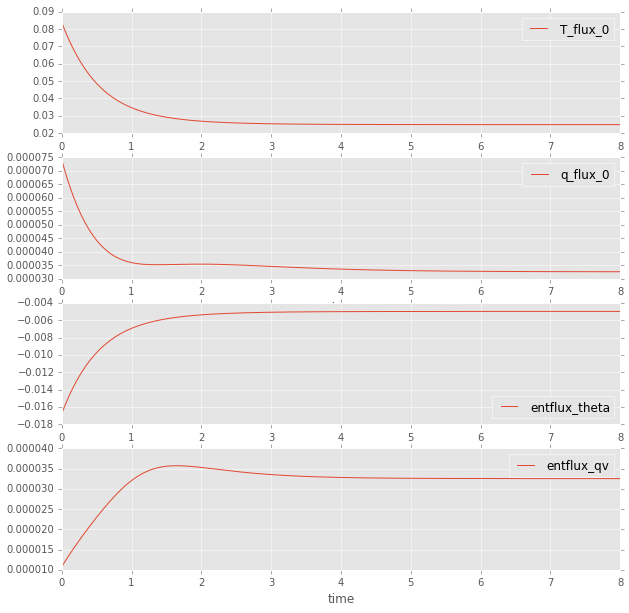

In [6]:
fig,ax=plt.subplots(4,1,figsize=(10,10))
result.plot('time','T_flux_0',ax=ax[0])
result.plot('time','q_flux_0',ax=ax[1])
result.plot('time','entflux_theta',ax=ax[2])
out=result.plot('time','entflux_qv',ax=ax[3])

In [7]:
result

,theta,h,qv,time,deltheta,delqv,LCL,q_flux_0,T_flux_0,thick,entflux_theta,went,entflux_qv,radcool
0,285.000000,400.000000,0.008000,0.000000,9.400000,-0.006000,192.075118,0.000074,0.084000,207.924882,-0.016800,0.001787,0.000011,30
1,285.105730,399.873895,0.008095,0.006944,9.293513,-0.006095,181.970835,0.000074,0.083260,217.903060,-0.016652,0.001792,0.000011,30
2,285.210168,399.750908,0.008188,0.013889,9.188337,-0.006188,172.270568,0.000073,0.082529,227.480341,-0.016506,0.001796,0.000011,30
3,285.313329,399.631058,0.008280,0.020833,9.084457,-0.006280,162.957966,0.000072,0.081807,236.673092,-0.016361,0.001801,0.000011,30
4,285.415225,399.514359,0.008371,0.027778,8.981861,-0.006371,154.017691,0.000072,0.081093,245.496668,-0.016219,0.001806,0.000012,30
5,285.515870,399.400832,0.008460,0.034722,8.880535,-0.006460,145.434951,0.000071,0.080389,253.965881,-0.016078,0.001810,0.000012,30
6,285.615281,399.290495,0.008549,0.041667,8.780462,-0.006549,137.195451,0.000070,0.079693,262.095045,-0.015939,0.001815,0.000012,30
7,285.713474,399.183372,0.008636,0.048611,8.681626,-0.006636,129.285583,0.000070,0.079006,269.897789,-0.015801,0.001820,0.000012,30
8,285.810462,399.079480,0.008722,0.055556,8.584015,-0.006722,121.692645,0.000069,0.078327,277.386835,-0.015665,0.001825,0.000012,30
9,285.906257,398.978836,0.008807,0.062500,8.487616,-0.006807,114.404591,0.000069,0.077656,284.574245,-0.015531,0.001830,0.000012,30


### Dump the result in an hdf file

In [8]:
with pd.HDFStore('dumpvapor.h5','w') as f:
    f.put('profile',result,format='table')

In [9]:
# modify mixed layer model for de Roode's parameterization for we

def dmixed_vars_equil(the_vars,tstep,coeffs):
    """
      the_vars[0]= thetabar
      the_vars[1] = h
      the_vars[2] = qv
      
      surface flux from drag law with subsidence and diagnosed deltheta
      we from de Roode lecture 2 slide 8
    """
    #print('the_vars: ',the_vars,D,U)
    deltheta = theta_ft(the_vars[1],coeffs.ft_intercept,coeffs.ft_gamma) - the_vars[0]
    F0 = coeffs.U*coeffs.Cd*(coeffs.sst - the_vars[0])  #surface heat flux
    Fqv0 = coeffs.U*coeffs.Cd*(coeffs.qsfc - the_vars[2])  #surface vapor flux
    #Fint = -coeffs.k*F0  #entrainment heat flux

    went = coeffs.eta*coeffs.radcool/deltheta  #entrainment velocity (positive upward) (from de Roode simple param.)
    Fint = (1-coeffs.eta)*went*deltheta
    Fqvent = -went*( coeffs.ft_qv - the_vars[2])
    wsubs = -coeffs.D*the_vars[1]
    rho=1.
    cp=1004.
    derivs=np.empty_like(the_vars)
    derivs[0]=(F0 - Fint)/(the_vars[1])  
    derivs[1] = went + wsubs
    derivs[2] = (Fqv0 - Fqvent)/the_vars[1]
    return derivs

In [10]:
# use parameters from de Roode lecture 2 slide 9
dtout=10.  #minutes
end_time=8*24.   #hours
del_time=dtout*60. #seconds
end_time=end_time*3600. #seconds
ssts=np.arange(270,296)
D=5.e-6  #s-1
U=10  #m/s
psfc=100. #kPa
qsfc=tf.qs_tp(sst,psfc)
ft_intercept = 288 #K
ft_gamma = 6.e-3  #K/m
ft_qv = 2.e-3
k=0.2  #entrainment efficiency
Cd = 1.e-3  #drag coefficient
eta = 0.8
radcool=0.035 # mKs-1

tspan = np.arange(0.,end_time,del_time)
vars_init=[285.,400.,8.e-3]  #theta (K), height (m) qv (kg/kg) to start
equil_output = np.empty([ssts.shape[0],3])
for sst_ind in range(ssts.shape[0]):
    the_tup=dict(D=D,U=U,sst=ssts[sst_ind],ft_intercept=ft_intercept,ft_gamma=ft_gamma,
                 qsfc=qsfc,ft_qv=ft_qv,k=k,Cd=Cd,radcool=radcool,eta=eta)
    the_tup=make_tuple('coeffs',the_tup)

    output=integrate.odeint(dmixed_vars_equil, vars_init, tspan,(the_tup,))
    equil_output[sst_ind,:] = output[-1,:] # append equilibrium values
    
result1=pd.DataFrame.from_records(equil_output,columns=['theta_equil','h_equil','qv_equil']) # add to new dataframe
result1['sst']=ssts

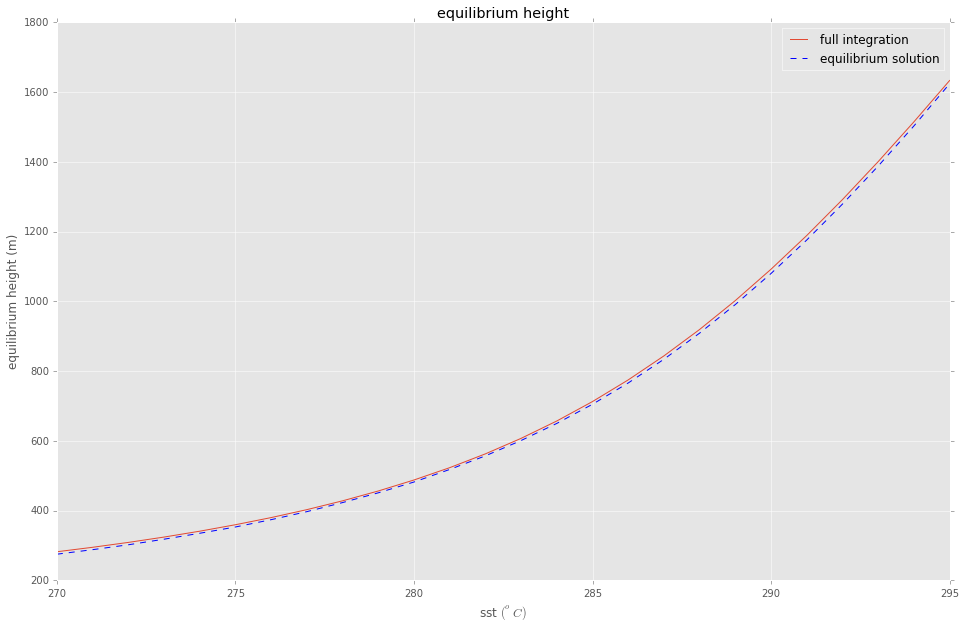

In [11]:
# de Roode entrainment parameterization -> equilibrium for h
# lecture 8 equilibrium equation for h

equil_h = np.empty_like(ssts)

for sst_ind in range(ssts.shape[0]):
    coeffs = np.empty([3])
    coeffs[0] = 1. # quadratic term
    coeffs[1] = 1/ft_gamma*(ft_intercept - ssts[sst_ind] + ((1-eta)*radcool)/(Cd*U)) # linear term
    coeffs[2] = -eta/(D*ft_gamma)*radcool # constant term
    h = np.roots(coeffs)
    if h[0] >= 0: # take positive root
        h = h[0]
    else:
        h = h[1]
    equil_h[sst_ind] = h
    
plt.close('all')
plt.style.use('ggplot')
fig,ax = plt.subplots(1,1,figsize=(16,10))
ax.plot(result1['sst'],result1['h_equil'],label='full integration')
ax.plot(result1['sst'],equil_h,'--b',label='equilibrium solution')
ax.set(ylabel='equilibrium height (m)',xlabel=r'sst $(^oC)$',title='equilibrium height')
ax.legend(loc='best')